# The project

In an era where technology evolves rapidly, the traditional mouse is becoming a relic of the past. Our project embraces this change, leveraging the power of modern computers equipped with advanced cameras, high-resolution screens, and powerful GPUs. Our objective? To develop an innovative eye-tracking model that accurately maps eye movements to screen coordinates, adaptable to varying lighting conditions, distances, head rotations, and offsets.



## Purpose of notebook

This is the training the models parameters to learn which screen co-ordinates the user is looking from the training dataset.  The training set consist of 2000 images and we're using fast.ai library.

# Break down of the notebook


- The script defines a path to the dataset of images (eye-tracking data).
- It normalizes the coordinates to be between 0 and 1, based on the screen resolution (width: 2560, height: 1440).
- A function get_y(fname) is defined to extract x and y coordinates from the filenames of the images.
- A DataBlock is created with specific configurations for eye-tracking (like ImageBlock, RegressionBlock, resizing images, and batch transforms).
- The images are resized to 480 and 680 to reduce computation and complexity of the model.  
- The script uses fastai’s vision_learner to create a learner with the resnet18 architecture, setting the y_range to (0,1).
- It finds an optimal learning rate using learn.lr_find().
- The model is trained using fine_tune method for 20 epochs with a learning rate of 1e-3 and freeze epochs of 3.
- After initial training, the model is fine-tuned further for 100 epochs with a specified learning rate slice.


# The results

The training loss is much higher than the validation loss. It's usually the other way around.  This maybe due to the data augmentation which is good.

The error on the validation is 0.00742	from a starting point of 0.067467.  Thats less than 1%.

The model size is still the same, it will be interesting to see if the throughput has slowed with more inputs.  

The

In [5]:
# Pixel loss on the validation
# this only slightly beats 100 pixels.
validation_loss_at_100_pochs = 0.00742
screen_width=2560
screen_height=1440
error_on_width = screen_width * validation_loss_at_100_pochs
error_on_height = screen_height * validation_loss_at_100_pochs

print(f"width pixel error {error_on_width}")
print(f"height pixel error {error_on_height}")

width pixel error 18.9952
height pixel error 10.684800000000001


# The code

## Setup enviroment and importing libraries

In [ ]:
!pip install fastbook -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00


In [ ]:
from fastai.basics import *
from fastai.imports import *
from fastai.vision.all import *
import datetime




In [ ]:
from fastbook import *

In [ ]:
#| echo: True
#| output: True
import os
import sys

In [ ]:
#| echo: True
#| output: True

# checks if the environment is local or remote
def check_if_local():
    # Checking for common remote environment indicators
    remote_indicators = ['COLAB_GPU', 'JUPYTERHUB_SERVICE_PREFIX']

    # If any of the indicators are present, it's likely not a local environment
    if any(indicator in os.environ for indicator in remote_indicators):
        return False
    else:
        # Assuming local environment if none of the remote indicators are found
        return True


In [ ]:
#| echo: True
#| output: False

# checks if the environment is local or remote and sets the path accordingly
if check_if_local() == False:
    print('Running in a remote environment, mounting Google Drive...')
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append('/content/drive/MyDrive/Learning/data_science/')
    model_folder = '/content/drive/MyDrive/Learning/data_science/models/eye-tracker'
else :
    print('Running in a local environment...')
    sys.path.append('G:\My Drive\Learning\data_science')



Running in a remote environment, mounting Google Drive...
Mounted at /content/drive


## Loading data and importing

In [ ]:

# dataset path
path = Path('/content/drive/MyDrive/Learning/data_science/datasets/gaze-points/work-laptop')
img_files = path.ls()

In [ ]:
# used for normalizing co-ordinates i.e. getting a value between 0 and 1
width = 2560
height = 1440


In [ ]:
def get_y(fname):
    """
    Extracts the x and y-coordinate from the given filename.

    Parameters:
    fname (str): The filename containing the coordinates.

    Returns:
    torch.Tensor: The y-coordinate extracted from the filename.
    """
    coords = fname.name.split('_')[1:]

    x, y = coords[0], coords[1].replace('.png', '') # assumes the files are formatted like so: "id_xcoord_ycoord.png"

    x = int(x)  / width
    y = int(y) / height
    coords = tensor([x,y])
    return coords

In [ ]:
"""
DataBlock for eye tracking.

Parameters:
- blocks: A tuple of blocks used for input and target. In this case, it consists of ImageBlock and RegressionBlock.
- get_items: A function that returns a list of input items. In this case, it is get_image_files.
- get_y: A function that returns the labels for the input items. In this case, it is get_y.
- splitter: A splitter object used to split the data into train and validation sets. In this case, it is RandomSplitter.
- item_tfms: A list of item transforms to be applied to the input items. In this case, it resizes the images to (240, 320).
- batch_tfms: A list of batch transforms to be applied to the input batches. In this case, it applies various augmentation transforms.

Returns:
- A DataBlock object configured for eye tracking.
"""
dbock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),  # Image and Regression target
    get_items=get_image_files,
    get_y=get_y,  # Get labels
    splitter=RandomSplitter(),
    item_tfms=Resize((480, 640)),  # Resize by half on both dims
    batch_tfms=[*aug_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_warp=0, max_lighting=0.35, p_lighting=.85)]
)




In [ ]:
"""
Load data using the `dataloaders` function from the `dbock` module.

Parameters:
- path (str): The path to the data.
- bs (int): The batch size for loading the data.

Returns:
- dls: The data loaders object.
"""
dls = dbock.dataloaders(path, bs=32) # Worth experimenting here, I did find lower batch sizes seemed to help, but worth trying a few nums

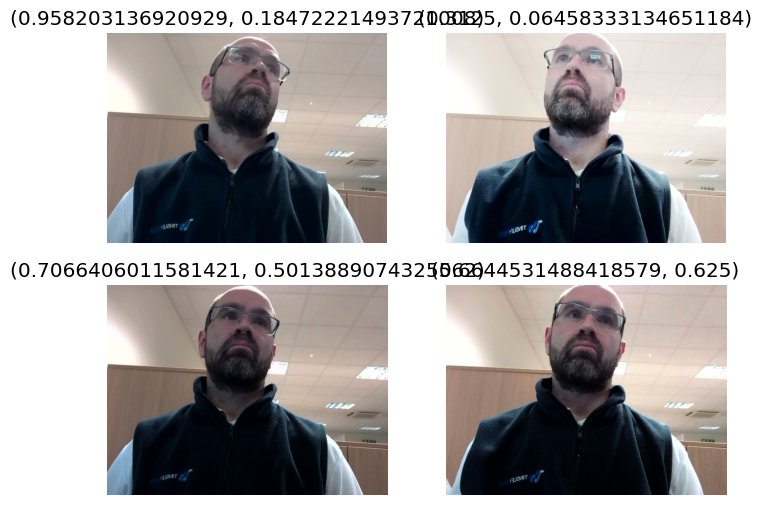

In [ ]:
dls.show_batch(max_n=4, figsize=(8,6))

# Setting up the model and finding the best learning rate

In [ ]:
"""
Create a vision learner object for eye tracking.

Parameters:
- dls: The data loader for the eye tracking dataset.
- resnet18: The ResNet18 model architecture.
- y_range: The range of the target variable. Set to (0,1) for better results.

Returns:
- learn: The vision learner object for eye tracking.
"""

learn = vision_learner(dls, resnet18, y_range=(0,1)) # for some reason y_range of (-1, 1) was super dodgy (the loss accounted for the different range), had 10x better results with 0-1



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


In [ ]:
learn.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0020892962347716093)

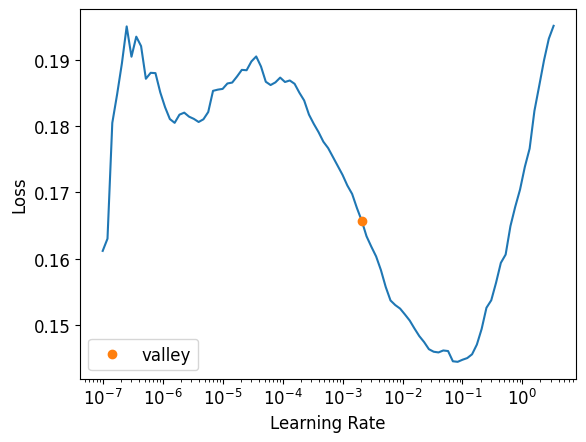

In [ ]:
learn.lr_find()

# Training the model and the results

In [ ]:
learn.fine_tune(20, 1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,time
0,0.155540,0.067467,00:39
1,0.109134,0.051982,00:36
2,0.089705,0.054042,00:36


epoch,train_loss,valid_loss,time
0,0.075852,0.046557,00:40
1,0.067004,0.043232,00:36
2,0.062067,0.039929,00:37
3,0.058724,0.037663,00:39
4,0.052484,0.031205,00:36
5,0.048081,0.025561,00:37
6,0.045942,0.027395,00:39
7,0.041393,0.019885,00:36
8,0.037100,0.018329,00:36
9,0.033679,0.014609,00:39


In [ ]:
def create_file_name_for_model(model_folder, description):
    # Get the current date and time
    now = datetime.now()

    # Format the date and time as a string
    date_time = now.strftime("%Y%m%d_%H%M%S")

    # Create the file name with the date and time
    file_name = f"{model_folder}/{date_time}_eye_tracker-{description}.pkl"

    return file_name

In [ ]:
description = "collected_another_1000_images_now_have_2000_higher_res_480_640"

In [ ]:
file_name = create_file_name_for_model(model_folder, description)
file_name

'/content/drive/MyDrive/Learning/data_science/models/eye-tracker/20240123_165631_eye_tracker-collected_another_1000_images_now_have_2000_higher_res_480_640.pkl'

In [ ]:
learn.export(file_name)

In [ ]:
learn.fit_one_cycle(100, slice(2e-5, 1e-7))

epoch,train_loss,valid_loss,time
0,0.015438,0.008891,00:38
1,0.016783,0.008842,00:36
2,0.017255,0.009114,00:38
3,0.016276,0.009064,00:38
4,0.016383,0.009042,00:37
5,0.016264,0.009036,00:46
6,0.016590,0.008981,00:44
7,0.016563,0.008757,00:43
8,0.016152,0.008550,00:42
9,0.015834,0.009013,00:44


epoch,train_loss,valid_loss,time
0,0.015438,0.008891,00:38
1,0.016783,0.008842,00:36
2,0.017255,0.009114,00:38
3,0.016276,0.009064,00:38
4,0.016383,0.009042,00:37
5,0.016264,0.009036,00:46
6,0.016590,0.008981,00:44
7,0.016563,0.008757,00:43
8,0.016152,0.008550,00:42
9,0.015834,0.009013,00:44


In [ ]:
def create_file_name_for_model(model_folder, description):
    # Get the current date and time
    now = datetime.now()

    # Format the date and time as a string
    date_time = now.strftime("%Y%m%d_%H%M%S")

    # Create the file name with the date and time
    file_name = f"{model_folder}/{date_time}_eye_tracker-{description}.pkl"

    return file_name

In [ ]:
description = "collected_another_1000_images_now_have_2000_further_fine_tuned_to_100_epochs_higher_res_480_640"

In [ ]:
file_name = create_file_name_for_model(model_folder, description)

In [ ]:
file_name

'/content/drive/MyDrive/Learning/data_science/models/eye-tracker/20240123_180449_eye_tracker-collected_another_1000_images_now_have_2000_further_fine_tuned_to_100_epochs_higher_res_480_640.pkl'

In [ ]:
learn.export(file_name)

In [ ]:
#handy if you run out of video memory
import gc

# Collect garbage
gc.collect()

# Empty PyTorch cache
torch.cuda.empty_cache()
